In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import copy

import matplotlib.pyplot as plt

In [6]:
from Gan_convolutional import Discriminator, Generator, generate_random_image, generate_random_one_hot, generate_random_seed 

In [5]:
# check CUDA is available

if torch.cuda.is_available():

    torch.set_default_tensor_type(torch.cuda.FloatTensor)# Using GPU to train

    print("Training cuda:", torch.cuda.get_device_name(0))
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training cuda: NVIDIA GeForce GTX 1050 Ti


In [6]:
#load data

data=[]
M_raw=[]

#there are 500 samples for each temperature
with h5py.File('../GAN/MC_2layers_T_BC.hdf5', 'r') as f:

    for i in np.arange(1,51):   
    
        dataset=f[str(i)+'.0K']

        data_M = dataset[:]
        M_raw.append(data_M.mean(axis=0).sum()/100)
    
        data.append(copy.deepcopy(dataset[:]))
data=np.array(data)
M_raw=np.array(M_raw)

data=data.reshape(-1,2,10,10)
data.shape

(25000, 2, 10, 10)

4256


array([-0.82667616,  0.86255125])

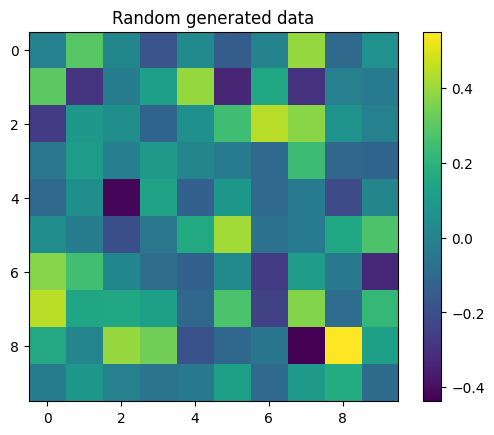

In [7]:
ii=np.random.randint(0,len(data))
print('Temperature: {} K'.format(int(ii/500)+1))
#original data plotting
plt.imshow(data[ii].sum(axis=0))#.cpu().detach().numpy()
plt.title('Random picked original data')
plt.colorbar()
print('The two layers magnetization are {} respectively'.format(data[ii].reshape(2,-1).sum(axis=1)/100))

In [8]:
data_num = 50
T = np.linspace(1,50,data_num)

#One hot encoding
One_hot_code=[]
for i in range(len(T)):
    for j in range(500):
        code=np.zeros(len(T))
        code[i]=1
        One_hot_code.append(code)
One_hot_code=np.array(One_hot_code)

#Transform the data into [0,1],turn into tensor
data_set=(data+1)/2
data_set=torch.tensor(data_set).to(torch.float32)

#Transform the one hot coding to tensor
One_hot_code=torch.tensor(One_hot_code).to(torch.float32)

print(data_set.detach().shape)
print(One_hot_code.detach().shape)

#Consolidate data and One hot coding
data_all=[]
for i in range(25000):
    data_all.append([data_set[i], One_hot_code[i]])

torch.Size([25000, 2, 10, 10])
torch.Size([25000, 50])


In [9]:
batch_size=250

data_loader = torch.utils.data.DataLoader(dataset=data_all,
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          generator=torch.Generator(device = 'cuda'))

## Train Discriminator

In [31]:
%%time
epochs=200
v_dim = 2*10*10
h_dim = 500
z_dim = 40
learning_rate = 2e-4
class_num=len(T)

model_D = Discriminator( h_dim=h_dim,learning_rate=learning_rate, class_num=class_num)
model_D.to(device)# move defined model to cuda device

losses = []#record train loss

for epoch in np.arange(epochs):

    train_loss=0 
    

    for image_data, label_tensor in data_loader:

        image_data = image_data.to(device)
        label_tensor = label_tensor.to(device)

        # real_imgs = image_data.view(-1,v_dim)

        model_D.train(image_data, label_tensor, torch.ones(batch_size,1))# torch.cuda.FloatTensor([1.0])
        train_loss += model_D.Loss.detach().item()

        # fake data
        model_D.train(generate_random_image(batch_size).cuda(), generate_random_one_hot(batch_size, class_num), torch.zeros(batch_size,1))
        train_loss += model_D.Loss.detach().item()
    
    if (epoch+1)%20==0:
        print('Epoch: {}, loss: {}'.format(epoch+1, train_loss / (2*len(data_loader))))

    losses.append(train_loss / (2*len(data_loader)))
        

Epoch: 20, loss: 0.11651124270632864
Epoch: 40, loss: 0.04726745547261089
Epoch: 60, loss: 0.016348294131457806
Epoch: 80, loss: 0.010782561208470725
Epoch: 100, loss: 0.009868584220930643
Epoch: 120, loss: 0.007514886311546434
Epoch: 140, loss: 0.007514440407394431
Epoch: 160, loss: 0.005895529588815407
Epoch: 180, loss: 0.004823342570261957
Epoch: 200, loss: 0.008460680531561593
Wall time: 14min 41s


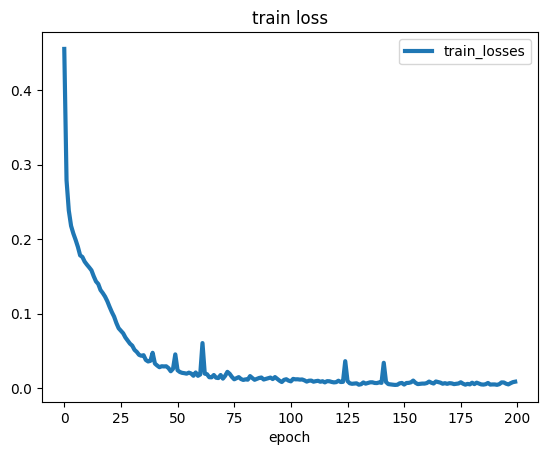

In [32]:
# plot discriminator loss
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses, linewidth=3, linestyle='-', label='train_losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [39]:
# manually run discriminator to check it can tell real data from fake
print('T')
for i in range(5): 
  
    A_label = np.random.randint(0,25000)
    image_data_tensor =data_set[A_label]# celeba_dataset[random.randint(0,20000)]

    One_hot_code_tensor=torch.zeros(class_num)
    One_hot_code_tensor[int(A_label/500)]=1.0

    print( model_D.forward( image_data_tensor.reshape(-1,2,10,10),One_hot_code_tensor.reshape(-1,50)).item() )
  
print('F')
for i in range(5):

    print( model_D.forward( generate_random_image(1).reshape(-1,2,10,10), generate_random_one_hot(1,50)).item() )

T
1.0
1.0
0.998761773109436
0.9999955892562866
1.0
F
0.00010607697913656011
9.16002956536242e-19
5.5499732830082145e-18
8.415728934669603e-18
6.855722176624113e-07


## Train GAN

In [21]:
%%time 
v_dim = 2*10*10
z_dim = 100#25#20
h_dim=500
learning_rate=1e-5#1e-4
epochs = 400#300
class_num = len(T)

# create Discriminator and Generator

D_model = Discriminator( h_dim=h_dim, learning_rate=learning_rate, class_num=class_num)
D_model.to(device)
G_model = Generator(h_dim=h_dim+500, z_dim=z_dim, learning_rate=learning_rate, class_num=class_num)#+400
G_model.to(device)#+500

D_losses = []
G_losses = []

for epoch in range(epochs):

    d_loss=0
    g_loss=0

    for image_data_tensor, label_tensor in data_loader:
        # image_data_tensor = torch.flatten(image_data_tensor)#, start_dim=1

        D_model.train(image_data_tensor, label_tensor, torch.ones(batch_size,1))#torch.cuda.FloatTensor([1.0])
        d_loss += D_model.Loss.detach().item()

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)

        D_model.train(G_model.forward(generate_random_seed(batch_size,z_dim), Genetated_random_hot).detach(), Genetated_random_hot, torch.zeros(batch_size,1)) # torch.cuda.FloatTensor([0.0])
        d_loss += D_model.Loss.detach().item()

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)

        G_model.train(D_model, generate_random_seed(batch_size,z_dim), Genetated_random_hot, torch.ones(batch_size,1) )#torch.cuda.FloatTensor([1.0])
        g_loss += G_model.Loss.detach().item()

    if (epoch+1)%20==0:
        print('Epoch: {}, D_loss: {}, G_loss: {}'.format(epoch+1, d_loss / (2*len(data_loader)),g_loss / len(data_loader)))

    D_losses.append(d_loss / (2*len(data_loader)))
    G_losses.append(g_loss / len(data_loader))

Epoch: 20, D_loss: 0.4747978428006172, G_loss: 1.4381149435043334
Epoch: 40, D_loss: 0.5011983618140221, G_loss: 1.5093391394615174
Epoch: 60, D_loss: 0.5199147807061673, G_loss: 1.50388636469841
Epoch: 80, D_loss: 0.538100888133049, G_loss: 1.4268247628211974
Epoch: 100, D_loss: 0.6868747213482856, G_loss: 0.7598086267709732
Epoch: 120, D_loss: 0.6983366903662681, G_loss: 0.7087111842632293
Epoch: 140, D_loss: 0.6980308973789215, G_loss: 0.695362184047699
Epoch: 160, D_loss: 0.6984124875068665, G_loss: 0.6901764297485351
Epoch: 180, D_loss: 0.6969475218653679, G_loss: 0.6960621279478073
Epoch: 200, D_loss: 0.6977844622731209, G_loss: 0.6886961477994918
Epoch: 220, D_loss: 0.698632108271122, G_loss: 0.6899322098493577
Epoch: 240, D_loss: 0.6987684026360512, G_loss: 0.6859459364414215
Epoch: 260, D_loss: 0.6996559825539589, G_loss: 0.6887549996376038
Epoch: 280, D_loss: 0.6935938858985901, G_loss: 0.693733679652214
Epoch: 300, D_loss: 0.6960034164786338, G_loss: 0.6872079253196717
Epoch

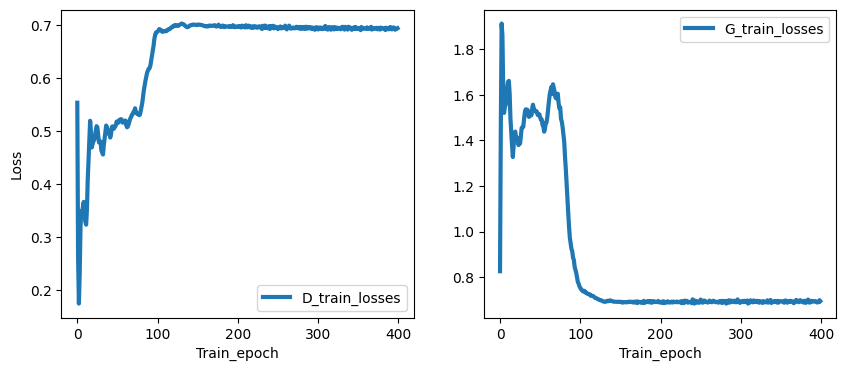

In [38]:
fig = plt.figure(figsize=(10,4)) 

ax1=plt.subplot(121)
ax1.plot(np.arange(len(D_losses)), D_losses, linewidth=3, linestyle='-', label='D_train_losses')
# ax1.set_title('Total_loss')
ax1.set_xlabel('Train_epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax1=plt.subplot(122)
ax1.plot(np.arange(len(G_losses)), G_losses, linewidth=3, linestyle='-', label='G_train_losses')
# ax1.set_title('Total_loss')
ax1.set_xlabel('Train_epoch')
# ax1.set_ylabel('Loss')
ax1.legend()

## Run Generator

[-0.77588916  0.7608989 ]


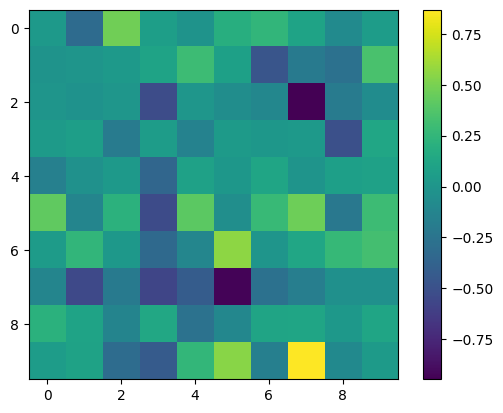

In [25]:
T_test=11
Code=torch.zeros(50)
Code[T_test-1]=1.0
output=G_model.forward(generate_random_seed(1,z_dim), Code.reshape(1,50))
img = output.detach().cpu().numpy().reshape(2,10,10)
generated_img=img*2-1
plt.imshow(generated_img.sum(axis=0))
plt.colorbar()

print(generated_img.sum(axis=1).sum(axis=1)/100)

## Create data for magnetic measurement

In [31]:
M_T=[]
Susceptibility = []
sample_num=500
for ii in range(0,len(T)):
    Code=torch.zeros(50)
    Code[ii]=1.0

    
    cal_M = 0
    cal_M_2=0
    for jj in range(sample_num):
        output=G_model.forward(generate_random_seed(1,z_dim), Code.reshape(1,50))
        img = output.detach().cpu().numpy().reshape(2,10,10)
        generated_img=img*2-1
        cal_M += generated_img.sum()/100
        cal_M_2 += (generated_img.sum()/100)**2
    cal_M = cal_M/sample_num
    cal_M_2 = cal_M_2/sample_num


    M_T.append(copy.deepcopy(cal_M))
    Susceptibility.append(copy.deepcopy((1/(ii+1))*(cal_M_2-cal_M**2)))

M_T=np.array(M_T)
Susceptibility=np.array(Susceptibility)

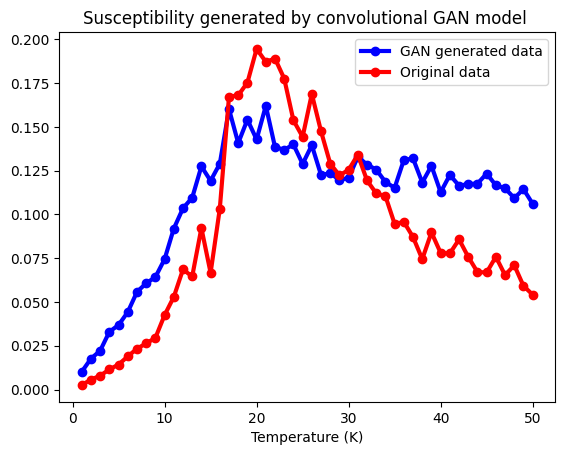

In [32]:
plt.plot(T, M_T,'bo-',markersize=6,lw=3,label='GAN generated data')
plt.plot(T,M_raw,'ro-',markersize=6,lw=3,label='Original data')
plt.title('Susceptibility generated by convolutional GAN model ')
plt.xlabel('Temperature (K)')
plt.legend()

Text(0.5, 0, 'Temperature (K)')

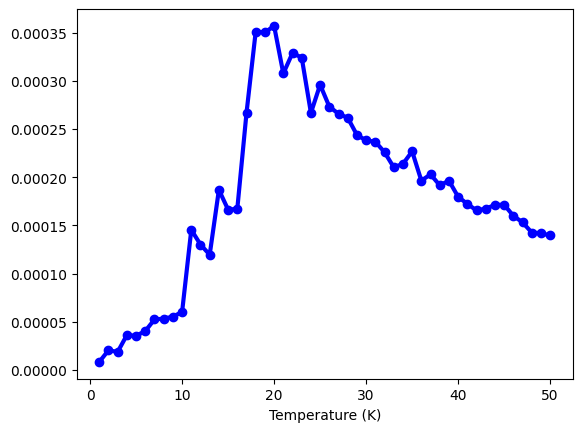

In [33]:
plt.plot(T, Susceptibility,'bo-',markersize=6,lw=3)
plt.xlabel('Temperature (K)')

## Model saving

In [34]:
# torch.save(G_model,"Trained_model_saving/G_convolutional_z100_h5001000_Ir1em5.pth")
# torch.save(D_model,"Trained_model_saving/D_convolutional_z100_h5001000_Ir1em5.pth")# saving the whole model

In [35]:
# reloaded_G=torch.load("Trained_model_saving/G_convolutional_z100_h5001000_Ir1em5.pth")
# reloaded_D=torch.load("Trained_model_saving/D_convolutional_z100_h5001000_Ir1em5.pth")

## Continue Training

In [79]:
%%time 
# v_dim = 2*10*10
z_dim = 100#25#20
h_dim=500
learning_rate=1e-5#1e-4
re_epochs = 2#300
class_num = len(T)
reD_losses = []
reG_losses = []

for epoch in range(re_epochs):

    d_loss=0
    g_loss=0

    for image_data_tensor, label_tensor in data_loader:
        # image_data_tensor = torch.flatten(image_data_tensor)#, start_dim=1

        reloaded_D.train(image_data_tensor, label_tensor, torch.ones(batch_size,1))#torch.cuda.FloatTensor([1.0])
        d_loss += reloaded_D.Loss.detach().item()

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)

        reloaded_D.train(reloaded_G.forward(generate_random_seed(batch_size,z_dim), Genetated_random_hot).detach(), Genetated_random_hot, torch.zeros(batch_size,1)) # torch.cuda.FloatTensor([0.0])
        d_loss += reloaded_D.Loss.detach().item()

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)

        reloaded_G.train(reloaded_D, generate_random_seed(batch_size,z_dim), Genetated_random_hot, torch.ones(batch_size,1) )#torch.cuda.FloatTensor([1.0])
        g_loss += reloaded_G.Loss.detach().item()

    if (epoch+1)%2==0:
        print('Epoch: {}, D_loss: {}, G_loss: {}'.format(epoch+1, d_loss / (2*len(data_loader)),g_loss / len(data_loader)))

    reD_losses.append(d_loss / (2*len(data_loader)))
    reG_losses.append(g_loss / len(data_loader))

Epoch: 2, D_loss: 0.6959997564554214, G_loss: 0.6905889481306076
Wall time: 21.7 s


In [80]:
M_T_re=[]
Susceptibility_re = []

sample_num=500

for ii in range(0,len(T)):

    Code=torch.zeros(50)
    Code[ii]=1.0
    
    cal_M = 0
    cal_M_2=0

    for jj in range(sample_num):
        
        output=reloaded_G.forward(generate_random_seed(1,z_dim), Code.reshape(1,50))
        img = output.detach().cpu().numpy().reshape(2,10,10)
        generated_img=img*2-1
        cal_M += generated_img.sum()/100
        cal_M_2 += (generated_img.sum()/100)**2

    cal_M = cal_M/sample_num
    cal_M_2 = cal_M_2/sample_num


    M_T_re.append(copy.deepcopy(cal_M))
    Susceptibility_re.append(copy.deepcopy((1/(ii+1))*(cal_M_2-cal_M**2)))

M_T_re=np.array(M_T_re)
Susceptibility_re=np.array(Susceptibility_re)

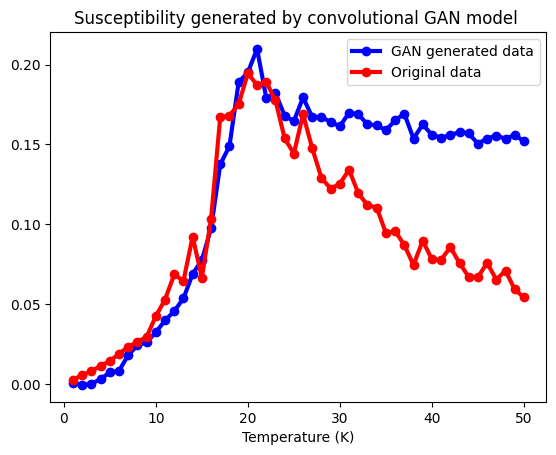

In [81]:
plt.plot(T, M_T_re,'bo-',markersize=6,lw=3,label='GAN generated data')
plt.plot(T,M_raw,'ro-',markersize=6,lw=3,label='Original data')
plt.title('Susceptibility generated by convolutional GAN model ')
plt.xlabel('Temperature (K)')
plt.legend()

Text(0.5, 0, 'Temperature (K)')

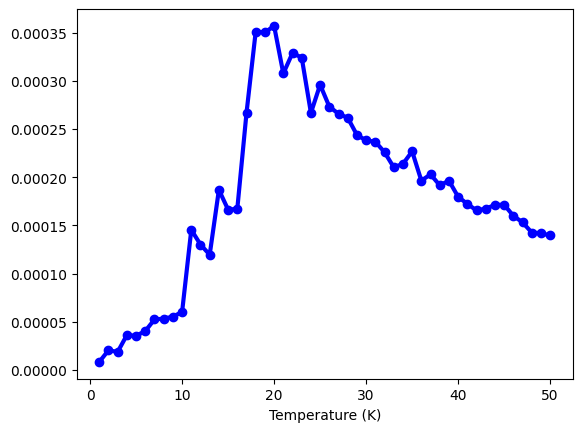

In [78]:
plt.plot(T, Susceptibility,'bo-',markersize=6,lw=3)
plt.xlabel('Temperature (K)')